In [23]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os  
import glob
import pickle
import math
%matplotlib inline

In [25]:
################ Defining Undistort Function ################
f_file = open("cal_info.pkl", "rb")
cal_info = pickle.load(f_file)
f_file.close()
def undistort(img):
    mtx = cal_info["mtx"]
    dist = cal_info["dist"]
    un_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return un_img

In [26]:
################ Defining Binary Image ################
def binary_image(img, s_thresh=(140, 255), sx_thresh=(50, 255)):
    ########### Binary image for Color #################
    # Going to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    ########## Binary image for Gradiant ##############
    # Converting to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Getting x derivative
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # Getting absolute value
    abs_sobelx = np.absolute(sobelx)
    # Scaling and Converting to 8-bit
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Applying thresholds
    sx_binary = np.zeros_like(gray)
    sx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Defining the binary and binay_color
    binary = np.zeros_like(s_binary)
    binary[(s_binary == 1) | (sx_binary == 1)] = 1
    color_binary = np.dstack((s_binary, sx_binary, np.zeros_like(sx_binary)))*255
    
    return binary, color_binary

In [27]:
################ Defining Perspective Transform Function ################
# Defining the image shape as a tuple
img_size = (img.shape[1], img.shape[0])
# Loading the already indentified perspective info
f_file = open("perspective_info", "rb")
perspective_info = pickle.load(f_file)
f_file.close()
# Grabbing the M and Minv matrix
M = perspective_info["M"]
Minv = perspective_info["Minv"]

def unperspective(img):
    un_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return un_img

In [34]:
################ Defining Histogram Function ################
def hist(img):
    # input for this function is the warped binary image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img_size[1]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    # The output is a 1D array of img.shape[1] length
    return histogram

In [28]:
test_images = glob.glob("..\\test_images\\*.jpg")
test_images

['..\\test_images\\straight_lines1.jpg',
 '..\\test_images\\straight_lines2.jpg',
 '..\\test_images\\test1.jpg',
 '..\\test_images\\test2.jpg',
 '..\\test_images\\test3.jpg',
 '..\\test_images\\test4.jpg',
 '..\\test_images\\test5.jpg',
 '..\\test_images\\test6.jpg']

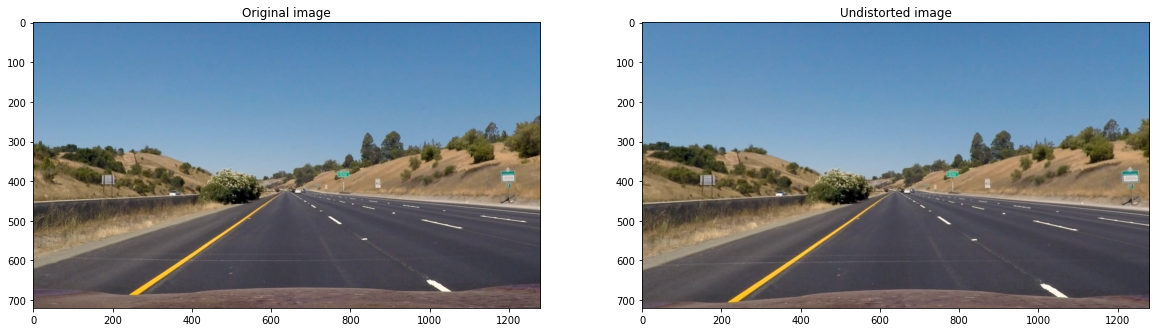

In [29]:
img = mpimg.imread(test_images[0])
un_img = undistort(img)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Original image")
ax1.imshow(img)
ax2.set_title("Undistorted image")
ax2.imshow(un_img)

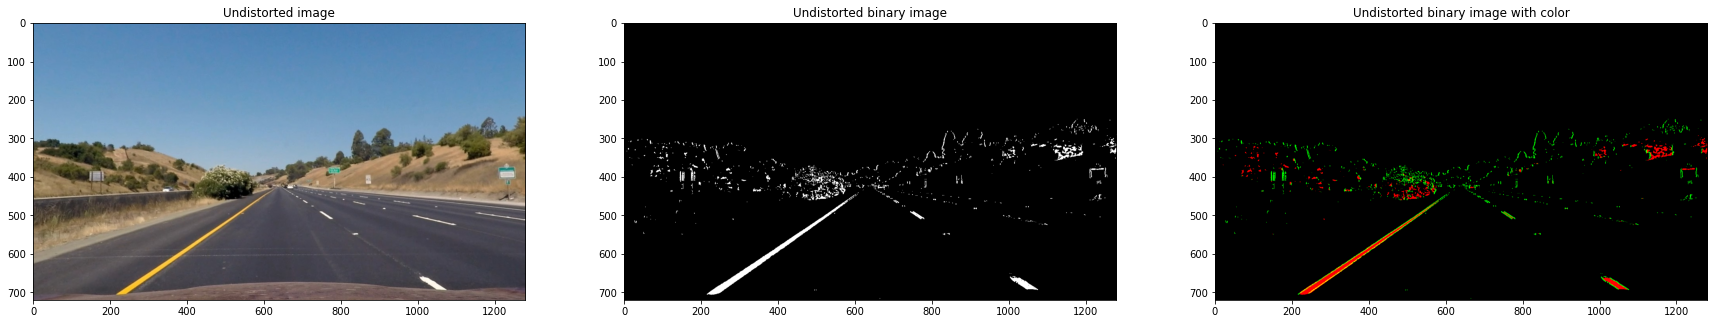

In [30]:
binary, binary_color = binary_image(un_img)
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.set_title("Undistorted image")
ax1.imshow(un_img)
ax2.set_title("Undistorted binary image")
ax2.imshow(binary, cmap='gray')
ax3.set_title("Undistorted binary image with color")
ax3.imshow(binary_color)

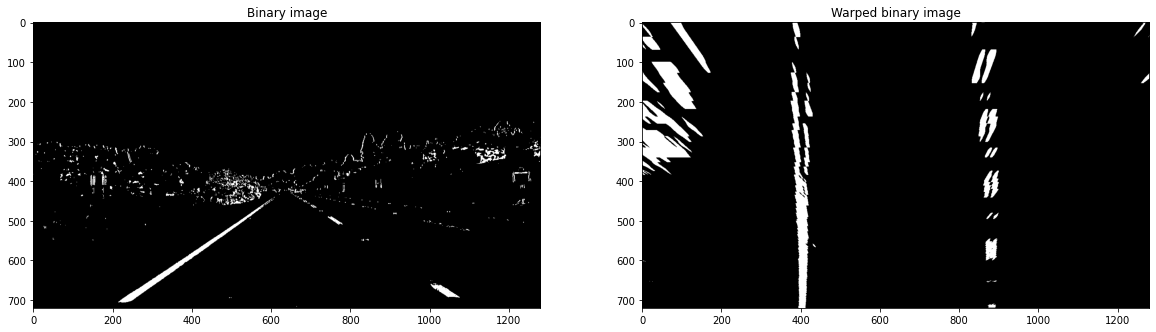

In [31]:
binary_warped = unperspective(binary)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Binary image")
ax1.imshow(binary, cmap='gray')
ax2.set_title("Warped binary image")
ax2.imshow(binary_warped, cmap='gray')


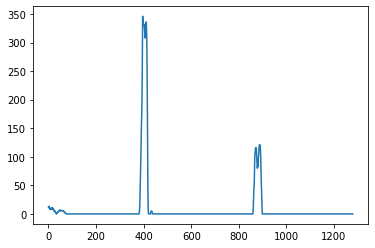

In [35]:
# Create histogram of image binary activations
histogram = hist(binary_warped)
# Visualize the resulting histogram
plt.plot(histogram)

In [37]:
# Setting up out_img for visualiztion
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
midpoint = np.int(img_size[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

396 887


In [64]:
def slide_search(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img_size[1]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

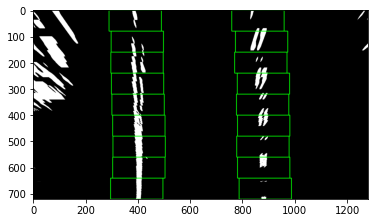

In [65]:
_, _, _, _, out_img = slide_search(binary_warped)
plt.imshow(out_img)

In [66]:
def poly_search(binary_warped, left_fit, right_fit):
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Visualization of the search area and margins
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, result

In [67]:
def fit_polynomial(binary_warped):
    # Find line pixels using slide_search
    leftx, lefty, rightx, righty, out_img = slide_search(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Finding line pixels using poly_search
    leftx, lefty, rightx, righty, out_img = poly_search(binary_warped, left_fit, right_fit)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

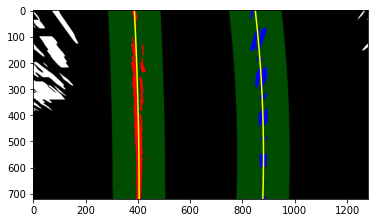

In [68]:
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

In [69]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [70]:
Left = Line()